In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import urllib
import os
import sys
import random
import glob
import re
import time
from io import StringIO
import bs4

%load_ext autoreload
%autoreload 2

sys.path.append("../")
from cleaner import *

In [2]:
docs = glob.glob("../data/raw/*.pdf")

In [18]:
t = docs[0]
t = '../data/raw/DH_Ministerial_gifts_hospitality_travel_and_external_meetings_Jan_to_Mar_2015.pdf'
t

'../data/raw/DH_Ministerial_gifts_hospitality_travel_and_external_meetings_Jan_to_Mar_2015.pdf'

In [4]:
from PDFFixup.fixer import *

In [19]:
get_tables(t)

[[[u'The Rt Hon Jeremy Hunt, Secretary of State for Health  rom   Gift '],
  ['', '', '', '', ''],
  [u'Date gift given F', '', u'Value  Outcome   '],
  [u'Dr. Dan Poulter / Parliamentary Under-Secretary for State for Health  '],
  [u'Date gift given ', u'F', '', u'Value  ', u'Outcome   '],
  ['', u'rom   Gift ', ''],
  [u'Norman Lamb MP, Minister of State for Care and Suppor  Gift '],
  ['', '', '', '', ''],
  [u'Date gift given ', u'From   ', '', u'Value  ', u'Outcome   '],
  [u'Jane Ellison MP, Parliamentary Under Secretary of State for Public Health  '],
  [u'Date gift given ', u'From   ', '', u'Value  ', u'Outcome   '],
  ['', '', u'Gift ', '', ''],
  [u'Earl Howe, Parliamentary Under-Secretary of State for Quality   '],
  ['', '', u'Gift ', '', ''],
  [u'Date gift given ', u'From   ', '', u'Value  ', u'Outcome   '],
  [u'The Rt Hon Jeremy Hunt, Secretary of State for Health  '],
  [u'Date gift received ', u'From   ', u'Gift ', u'Value  ', u'Outcome   '],
  ['', '', '']],
 [[u'Nor

In [20]:
pages = extract_layout_by_page(t)
page = pages[4]

In [25]:
from collections import defaultdict

texts = []
rects = []
other = []

for e in page:
    if isinstance(e, pdfminer.layout.LTTextBoxHorizontal):
        texts.append(e)
    elif isinstance(e, pdfminer.layout.LTRect):
        rects.append(e)
    else:
        other.append(e)

# convert text elements to characters
# and rectangles to lines
characters = extract_characters(texts)
lines = [cast_as_line(r) for r in rects
         if width(r) < 2 and
         area(r) > 1]

# match each character to a bounding rectangle where possible
box_char_dict = {}
for c in characters:
    
    # choose the bounding box that occurs the majority of times for each of these:
    bboxes = defaultdict(int)
    l_x, l_y = c.bbox[0], c.bbox[1]
    bbox_l = find_bounding_rectangle((l_x, l_y), lines)
    bboxes[bbox_l] += 1
    
    c_x, c_y = math.floor((c.bbox[0] + c.bbox[2]) / 2), math.floor((c.bbox[1] + c.bbox[3]) / 2)
    bbox_c = find_bounding_rectangle((c_x, c_y), lines)
    bboxes[bbox_c] += 1
    
    u_x, u_y = c.bbox[2], c.bbox[3]
    bbox_u = find_bounding_rectangle((u_x, u_y), lines)
    bboxes[bbox_u] += 1
    
    # if all values are in different boxes, default to character center.
    # otherwise choose the majority.
    if max(bboxes.values()) == 1:
        bbox = bbox_c
    else:
        bbox = max(bboxes.items(), key=lambda x: x[1])[0]
    
    if bbox is None:
        continue

    if bbox in box_char_dict.keys():
        box_char_dict[bbox].append(c)
        continue

    box_char_dict[bbox] = [c]

# look for empty bounding boxes by scanning
# over a grid of values on the page
for x in range(100, 500, 50):
    for y in range(50, 800, 10):
        bbox = find_bounding_rectangle((x, y), lines)

        if bbox is None:
            continue

        if bbox in box_char_dict.keys():
            continue

        box_char_dict[bbox] = []

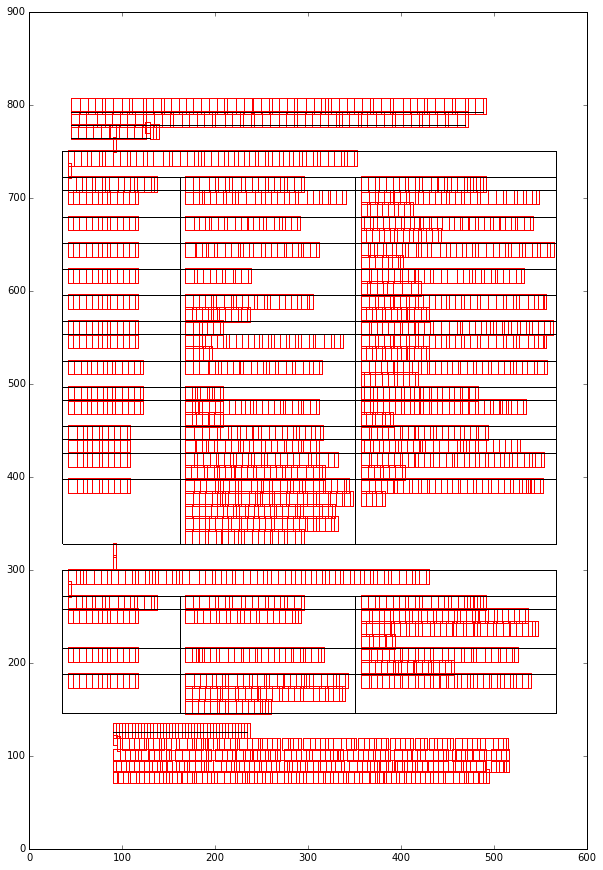

In [22]:
def draw_rect(rect, ax, color="black"):
    draw_rect_bbox(rect.bbox, ax, color)
    
def draw_rect_bbox((x0,y0,x1,y1), ax, color):
    ax.add_patch( 
        patches.Rectangle(
            (x0, y0),
            x1 - x0,
            y1 - y0,
            fill=False,
            color=color
        )    
    )
    

from matplotlib import patches

fig, ax = plt.subplots(figsize = (10,15))

for t in characters:
    draw_rect(t, ax, "r")
    
for l in lines:
    x0,y0,x1,y1,_ = l
    plt.plot([x0,x1],[y0,y1], "k-")
    
plt.xlim(0,600)
plt.ylim(0,900)
plt.show()

In [26]:
clean.pdf_cleaner.PDFFixup.fixer.boxes_to_table(box_char_dict)

[[u'The Rt Hon Jeremy Hunt, Secretary of State for Health '],
 [u'Date of Meeting  ',
  u'Name of Organisation ',
  u'Purpose of Meeting       '],
 [u'January 2015 ',
  u'College of Emergency Medicine ',
  u'Catch-up discussion on NHS winter pressures '],
 [u'January 2015 ',
  u'Ovarian Cancer Action ',
  u'Introductory discussion on ovarian cancer services '],
 [u'January 2015 ',
  u'World Health Organisation ',
  u'Bi-lateral with Margaret Chan, Director General '],
 [u'January 2015 ',
  u'Greene King ',
  u'Discussion on Dementia Friends programme '],
 [u'January 2015 ',
  u'Royal College of General Practitioners ',
  u'Catch-up discussion on NHS primary care services '],
 [u'January 2015 ', u'Unison ', u'Discussion on NHS industrial relations '],
 [u'January 2015 ',
  u'National Association of Primary Care ',
  u'Catch-up discussion on NHS primary care services '],
 [u'February 2015 ',
  u'Cambridge Health Network ',
  u'Roundtable discussion on healthcare technology '],
 [u'Februa

In [23]:
chars_to_string

defaultdict(int, {None: 3})